In [143]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import json
import numpy as np
import matplotlib.pyplot as plt

## Load in original coordinate set for all occurrences, remove points with imprecise coordinates

In [144]:
points = pd.read_csv('../data/csv/osmia_clustering_points.csv')
points = points.drop(columns='Unnamed: 0')
print(f'{len(points)} before')
points = points[points.apply(lambda row: (len(str(row['lat']).split('.')[-1]) >= 4) or 
                                        (len(str(row['lon']).split('.')[-1]) >= 4), axis=1)]
print(f'{len(points)} after')
# points

13929 before
8054 after


,lat,lon,date
0,51.024975,13.791615,1397347200000
1,51.024975,13.791615,1397692800000
2,51.024975,13.791615,1396396800000
3,51.024975,13.708278,1396483200000
4,51.024975,13.708278,1366848000000
...,...,...,...
13924,47.378670,8.509957,1428883200000
13925,42.342682,-4.275853,1428710400000
13926,49.450183,7.565188,1366070400000
13927,49.315423,8.391285,1366675200000


## Convert to geodataframe, coarsely filter for points withinin 1000m of another point

In [145]:
gdf = gpd.GeoDataFrame(points, geometry=[Point(xy) for xy in zip(points.lon, points.lat)])
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs("EPSG:32633")
index = gdf.sindex
to_drop = []

for i, geometry in enumerate(gdf.geometry):
    possible_matches_index = list(index.intersection(geometry.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.distance(geometry) < 1000]
    if len(precise_matches) > 1: 
        to_drop.append(gdf.index[i])


filtered_gdf = gdf.drop(index=to_drop)

filtered_df = pd.DataFrame(filtered_gdf.drop(columns='geometry'))


In [146]:
# filtered_df

,lat,lon,date
9,49.116177,10.110083,1365811200000
13,52.075497,8.498955,1366588800000
16,51.500088,10.798531,1396310400000
17,51.499126,9.761353,1368057600000
23,49.735462,8.747891,1365897600000
...,...,...,...
13924,47.378670,8.509957,1428883200000
13925,42.342682,-4.275853,1428710400000
13926,49.450183,7.565188,1366070400000
13927,49.315423,8.391285,1366675200000


In [147]:
# filtered_df.to_csv('osmia_points_filtered.csv', index=False)

## Import dataset with feature values from GEE

In [148]:
all_features = pd.read_csv('osmia_all_features_filtered.csv')
# all_features

,system:index,NDBI,NDVI,NDWI,SR_B2,SR_B3,SR_B4,SR_B5,ST_B10,date,precipitation,.geo
0,00000000000000000a75,-0.084276,0.000913,0.071552,38739.029552,37359.519581,38261.097038,38327.136272,33842.843858,1364774400000,0.043013,"{""type"":""Point"",""coordinates"":[4.5157806869362..."
1,00000000000000000a5f,-0.175859,0.285463,-0.096961,7082.628990,11340.963600,10926.196158,19662.662502,36251.642135,1364860800000,0.124731,"{""type"":""Point"",""coordinates"":[3.5998278213458..."
2,00000000000000000a8b,-0.108798,0.154637,-0.065444,10323.055141,12818.957352,13313.624138,18190.745979,36939.615379,1364860800000,0.139508,"{""type"":""Point"",""coordinates"":[4.0284945829167..."
3,00000000000000000aa5,-0.180956,-0.005086,0.179126,47119.043441,46091.388580,46743.162920,46287.575569,33993.125045,1364860800000,0.157984,"{""type"":""Point"",""coordinates"":[4.8679292744300..."
4,00000000000000000b9f,-0.137325,0.190217,-0.063773,10164.156371,12685.154073,12931.591366,19017.707298,36719.045108,1364860800000,0.139508,"{""type"":""Point"",""coordinates"":[4.0277008629292..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3172,00000000000000000049,-0.111172,0.070043,0.038602,24974.259222,24735.663755,24877.694723,28624.703963,32863.401718,1687910400000,NaN,"{""type"":""Point"",""coordinates"":[9.6032760972379..."
3173,0000000000000000001f,-0.227086,-0.011840,0.235296,43701.222817,42319.105808,42598.524615,41614.653396,36131.758205,1688688000000,NaN,"{""type"":""Point"",""coordinates"":[2.4381160602957..."
3174,00000000000000000021,-0.220396,-0.006220,0.219336,49663.392505,48617.070878,49339.481941,48735.028194,36129.045039,1688688000000,NaN,"{""type"":""Point"",""coordinates"":[2.4421426285470..."
3175,000000000000000000a9,-0.138350,0.236486,-0.082539,9662.132598,11280.372028,10861.471601,17585.041637,36847.216584,1691625600000,NaN,"{""type"":""Point"",""coordinates"":[6.4260016099187..."


## Filter for missing values

In [149]:

all_features = all_features[['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI', 'NDWI',  
         'date', '.geo']]
all_features['geometry'] = all_features['.geo'].apply(lambda x: Point(json.loads(x)['coordinates']))
all_features = all_features.drop(columns='.geo')
gdf = gpd.GeoDataFrame(all_features, geometry='geometry')
gdf = gdf.dropna()
gdf.set_crs(epsg=4326, inplace=True)
# gdf


/tmp/ipykernel_500676/677833591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features['geometry'] = all_features['.geo'].apply(lambda x: Point(json.loads(x)['coordinates']))


,SR_B2,SR_B3,SR_B4,SR_B5,ST_B10,NDBI,NDVI,NDWI,date,geometry
0,38739.029552,37359.519581,38261.097038,38327.136272,33842.843858,-0.084276,0.000913,0.071552,1364774400000,POINT (4.51578 50.47511)
1,7082.628990,11340.963600,10926.196158,19662.662502,36251.642135,-0.175859,0.285463,-0.096961,1364860800000,POINT (3.59983 50.48343)
2,10323.055141,12818.957352,13313.624138,18190.745979,36939.615379,-0.108798,0.154637,-0.065444,1364860800000,POINT (4.02849 50.75024)
3,47119.043441,46091.388580,46743.162920,46287.575569,33993.125045,-0.180956,-0.005086,0.179126,1364860800000,POINT (4.86793 50.46999)
4,10164.156371,12685.154073,12931.591366,19017.707298,36719.045108,-0.137325,0.190217,-0.063773,1364860800000,POINT (4.02770 50.74975)
...,...,...,...,...,...,...,...,...,...,...
3172,24974.259222,24735.663755,24877.694723,28624.703963,32863.401718,-0.111172,0.070043,0.038602,1687910400000,POINT (9.60328 50.51658)
3173,43701.222817,42319.105808,42598.524615,41614.653396,36131.758205,-0.227086,-0.011840,0.235296,1688688000000,POINT (2.43812 51.03978)
3174,49663.392505,48617.070878,49339.481941,48735.028194,36129.045039,-0.220396,-0.006220,0.219336,1688688000000,POINT (2.44214 51.04042)
3175,9662.132598,11280.372028,10861.471601,17585.041637,36847.216584,-0.138350,0.236486,-0.082539,1691625600000,POINT (6.42600 51.16100)


## Map points for sanity check

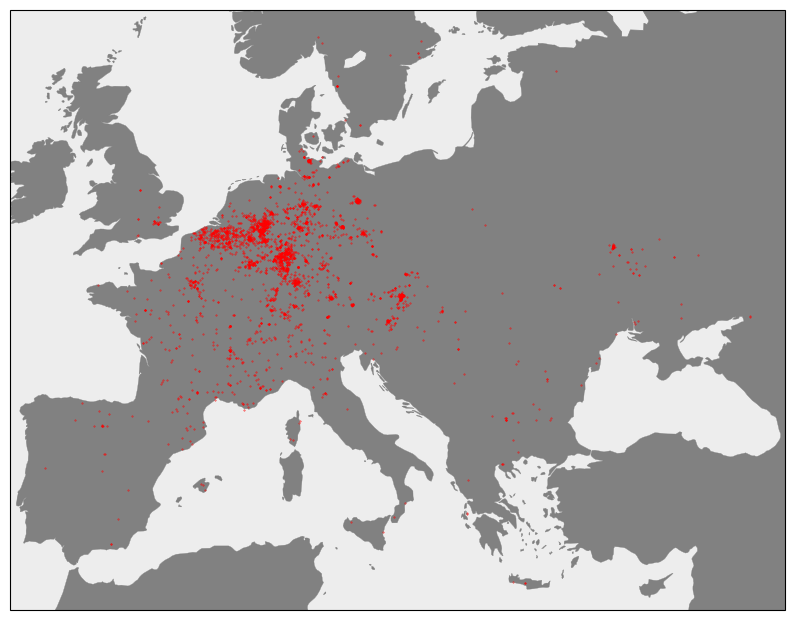

In [150]:

import cartopy.feature as cfeature
import cartopy.crs as ccrs

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

gdf.plot(ax=ax, markersize=.11, c='r') 

## Select features, cap spectral range to limit cloud interference

In [151]:
gdf = gdf[gdf['SR_B2']<12000]

In [152]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# feature_matrix = gdf[['x', 'y', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI', 'NDWI']].copy()
feature_matrix = gdf[['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI', 'NDWI']].copy() # without lat/lon
# feature_matrix = gdf[['SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI']].copy() # focus on vegetation/urban
# feature_matrix = gdf[['ST_B10', 'NDBI', 'NDVI', 'NDWI']].copy() # metrics only


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Normalize features

In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

feature_matrix_scaled = scaler.fit_transform(feature_matrix)
# feature_matrix_scaled

array([[-2.27617757,  0.9736961 ,  0.64118534, ..., -1.10190122,
         0.46629521,  0.96329372],
       [ 1.59753764,  2.2659895 ,  2.48903972, ..., -0.11236145,
        -1.06341257,  1.63203624],
       [ 1.40758466,  2.14899774,  2.19334873, ..., -0.53329845,
        -0.6473841 ,  1.66749058],
       ...,
       [-0.24601122,  0.50191635,  0.44482146, ..., -0.18790072,
         0.92438363, -1.50140764],
       [ 0.80744844,  0.92071746,  0.59108894, ..., -0.54842164,
        -0.10637943,  1.26931038],
       [ 0.80358036,  1.66627955,  1.8022725 , ...,  0.03685815,
        -0.09953823, -0.23329784]])

## Plot feature distributions for sanity check

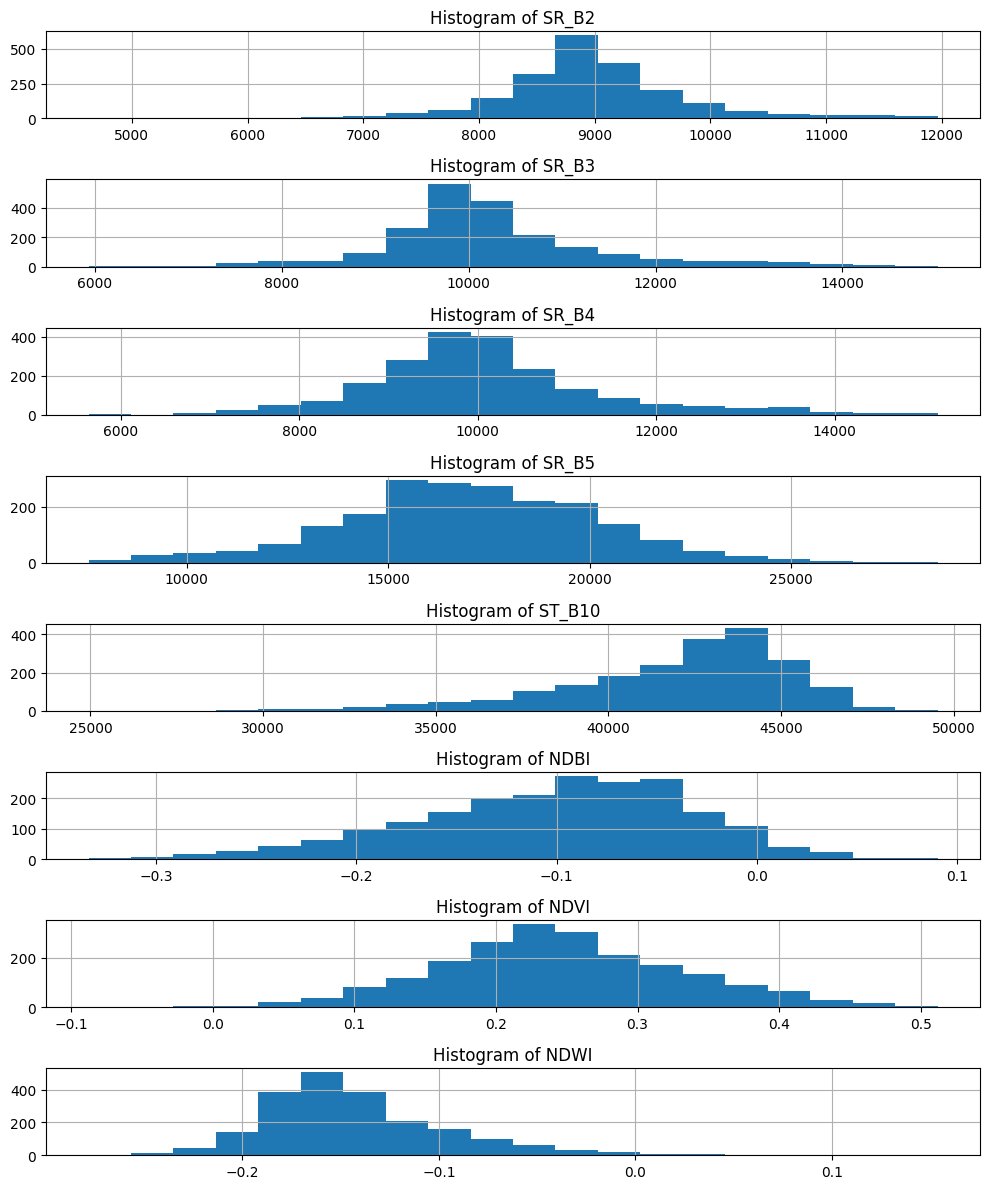

In [154]:
plt.figure(figsize=(10, 1 * len(gdf.columns)))

for i, column in enumerate(feature_matrix.columns):
    plt.subplot(len(feature_matrix.columns), 1, i + 1)
    feature_matrix[column].hist(bins=20)
    plt.title(f'Histogram of {column}')

plt.tight_layout()

## Elbow plot for informed K choice

In [155]:
# from sklearn.cluster import KMeans

# inertias = []
# range_of_clusters = range(1, 10)

# for k in range_of_clusters:
#     kmeans = KMeans(n_clusters=k).fit(feature_matrix_scaled)
#     inertias.append(kmeans.inertia_)

# plt.figure(figsize=(8, 4))
# plt.plot(range_of_clusters, inertias, '-o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Plot')
# plt.show()

## Plot clustering results

/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

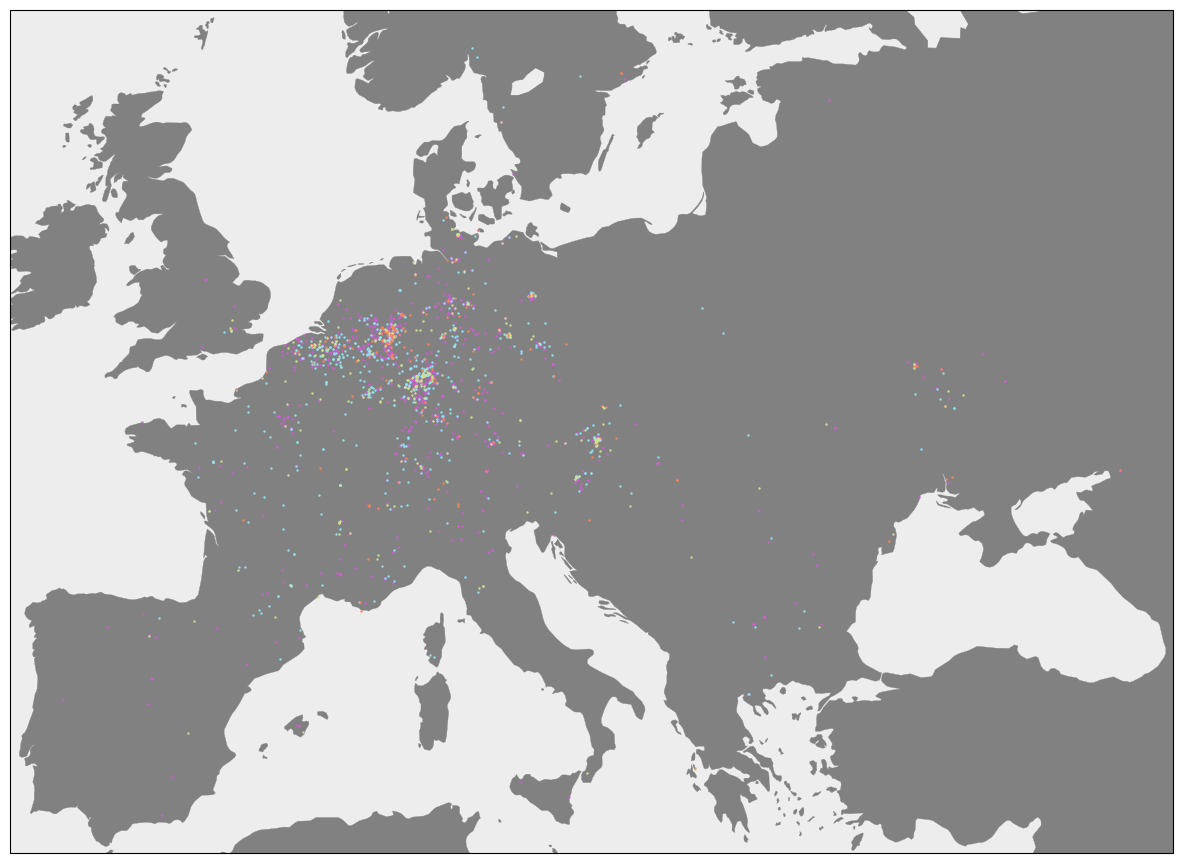

In [164]:


kmeans = KMeans(n_clusters=4)
gdf['k_cluster'] = kmeans.fit_predict(feature_matrix_scaled)


/home/mpgetz/miniconda3/envs/bee_mapping/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


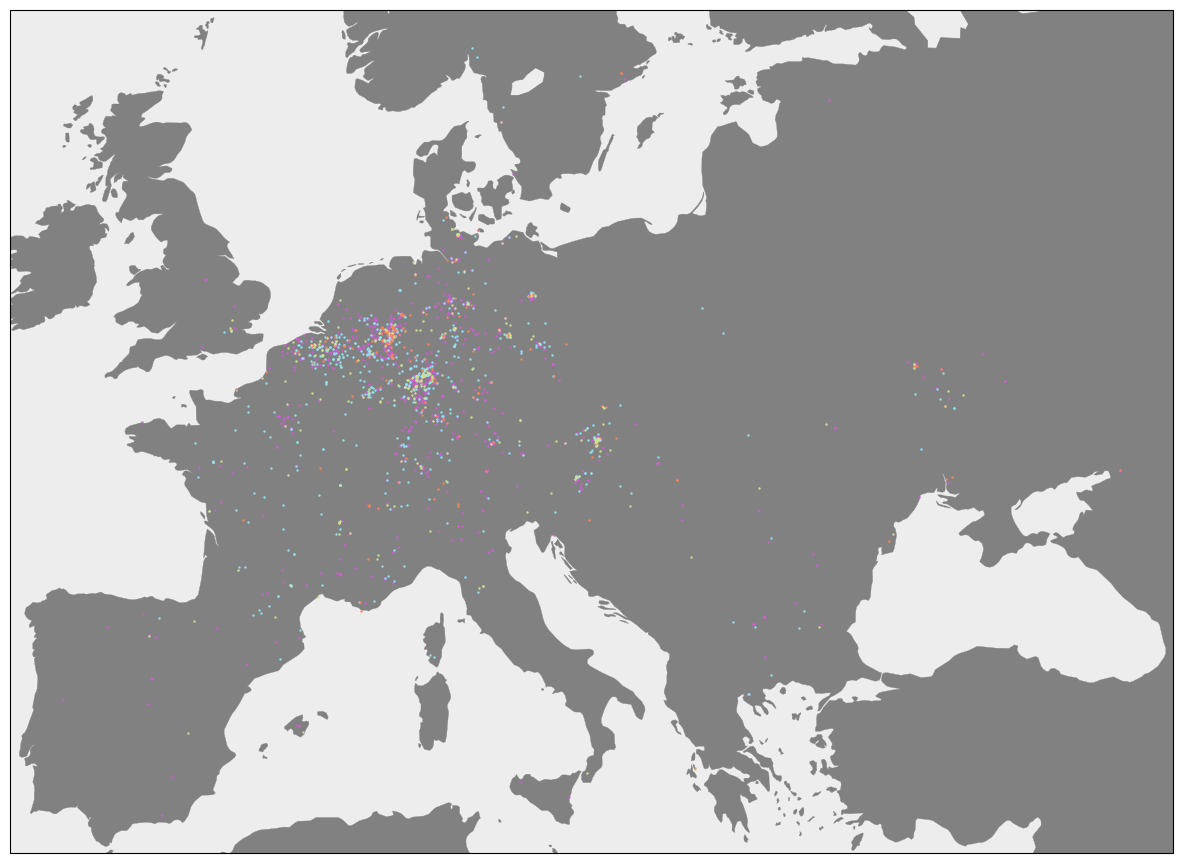

In [167]:

colors = ['#D15CD7', '#8EE3F5', '#FC8559', '#CCE38D']

gdf['cluster_color'] = gdf['k_cluster'].map(dict(enumerate(colors)))

plt.subplots(figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

for color in colors:
    gdf_subset = gdf[gdf['cluster_color'] == color]
    gdf_subset.plot(ax=ax, markersize=.5, color=color)

In [174]:
gdf['k_cluster'].value_counts()

k_cluster
0    998
1    598
3    280
2    204
Name: count, dtype: int64

## Investigate structure of class results

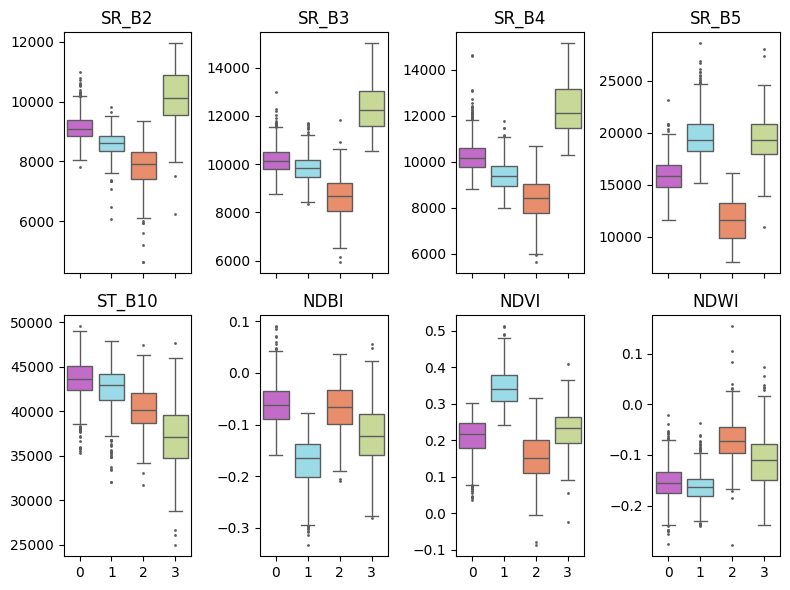

In [175]:
colors = ['#D15CD7', '#8EE3F5', '#FC8559', '#CCE38D']
gdf_subset = gdf[['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI', 'NDWI', 'k_cluster']]

fig, axes = plt.subplots(2, 4, figsize=(8, 6), sharex=True)

axes = axes.flatten()

for i, feature in enumerate(gdf_subset.columns[:-1]):
    ax = axes[i]
    sns.boxplot(x='k_cluster', y=feature, data=gdf_subset, fliersize=1, hue='k_cluster', palette=colors, ax=ax)

    ax.set_title(f'{feature}')

    ax.legend([],[], frameon=False)
    ax.set_xlabel('')  
    ax.set_ylabel('') 

plt.tight_layout()

In [1]:
# colors = ['#D15CD7', '#8EE3F5', '#FC8559', '#CCE38D']
# gdf_subset = gdf[['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'ST_B10', 'NDBI', 'NDVI', 'NDWI', 'k_cluster']]

# import seaborn as sns
# for feature in gdf_subset.columns[:-1]:
#     plt.figure(figsize=(1.5, 5))
#     sns.boxplot(x='k_cluster', y=feature, data=gdf_subset, fliersize=1, hue='k_cluster', palette=colors)
#     plt.title(f'{feature}')
#     plt.legend([],[], frameon=False)
#     plt.xlabel('')  
#     plt.ylabel('') 




## Export back to GEE

In [166]:
# gdf[['x', 'y', 'k_cluster']].to_csv('cluster_k_4_filtered_capped.csv', index=False)